Forecasting electricity demand is an extremely relevant problem for energy providers, as it influences not only the cost of day to day operations but also the timeliness and effectiveness of preparing for extreme weather conditions. Additionally, providers have to account for variations in geographic locations, further increasing the complexity of forecasting tasks. 

In this blog post, I aim to explore the applications and performance of several forecasting methods for this task. I'm specifically using the Australian New South Wales Electricity Market dataset, which features the electricity price and demand of New South Wales and Victoria, as well as the amount transferred between the two states.

The data contains 45,312 instances for the days from May 7, 1996 to December 5, 1998, with observations recorded every half hour in each 24 hour period. I account for this granularity in my approach.

In [29]:
#| echo: false
#| label: library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sktime.split import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sktime.utils.plotting import plot_series, plot_lags, plot_correlations
from sktime.transformations.series.detrend import STLTransformer

from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.fbprophet import Prophet

In [2]:
#| echo: false
#| cache: true
#| label: read and process data

electricity = pd.read_csv("C:/Users/jrh25/Desktop/personal-site/data/electricity.csv")
electricity['day'] = electricity['day'].str.replace("b'", "").str.replace("'", "")
electricity['class'] = electricity['class'].str.replace("b'", "").str.replace("'", "")

In [3]:
#| echo: true

electricity.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN


The data has a very fine level of granularity, making for a highly dense time series plot for the entire series. Right off the bat we can observe a longer term seasonality in the trend line of the graph.

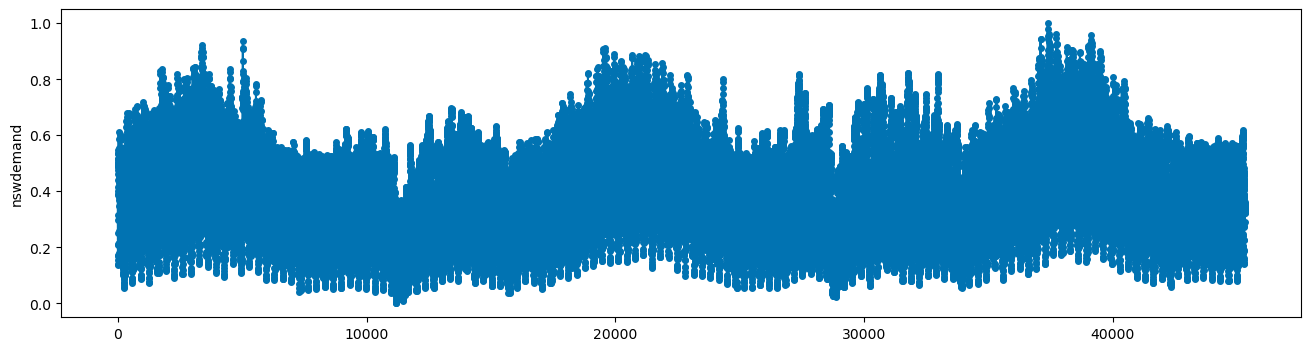

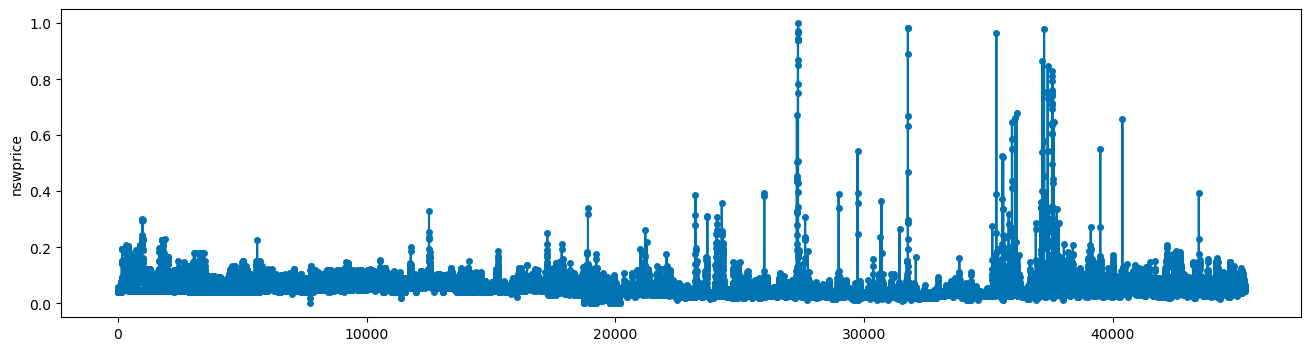

In [4]:
fig, ax = plot_series(electricity['nswdemand'])
fig, ax = plot_series(electricity['nswprice'])

Plotting a couple smaller length sections of the series (in intervals of 1000 observations) lets us see smaller scale seasonalities, which are immediately discernable.

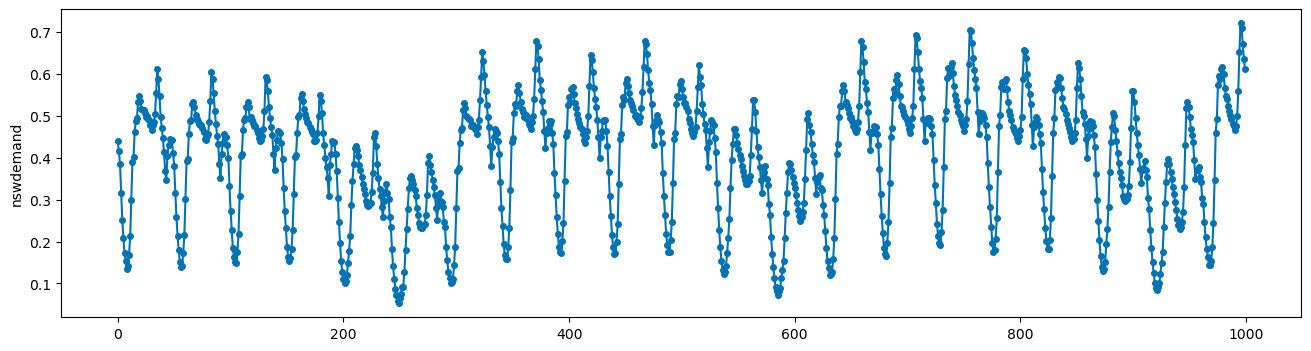

In [5]:
fig, ax = plot_series(electricity['nswdemand'][0:1000])

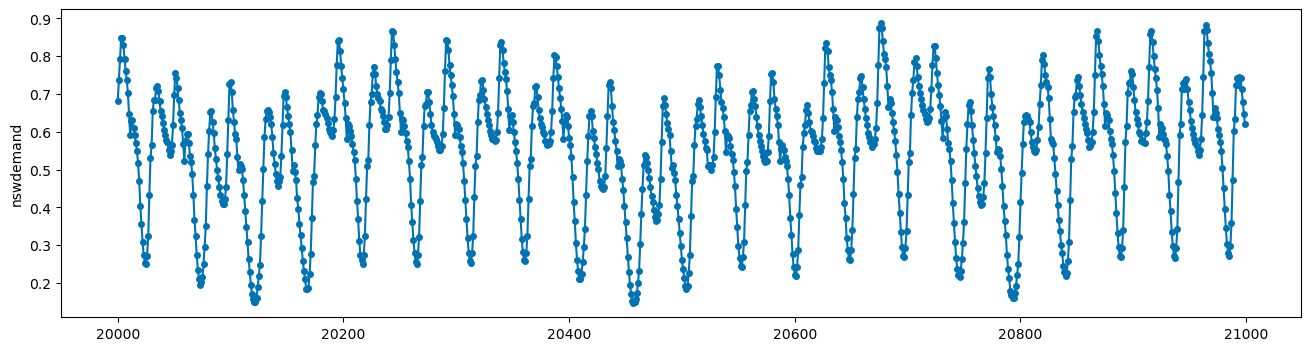

In [6]:
fig, ax = plot_series(electricity['nswdemand'][20000:21000])

The magnitude of seasonal variations doesn't appear to be influenced by the length of the time series, so I assume an additive decomposition to be the most appropriate such that

$y_t = S_t + T_t + R_t$

where data is decomposed into seasonal, trend, and remainder components respectively.

This data doesn't contain any missing values:

In [27]:
# Checking for missing values
missing_values = electricity.isna().sum()
print(missing_values)

date         0
day          0
period       0
nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
class        0
dtype: int64


Now let's perform an STL decomposition to get an idea of the seasonal and trend-cycle components of our data.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='resid'>)

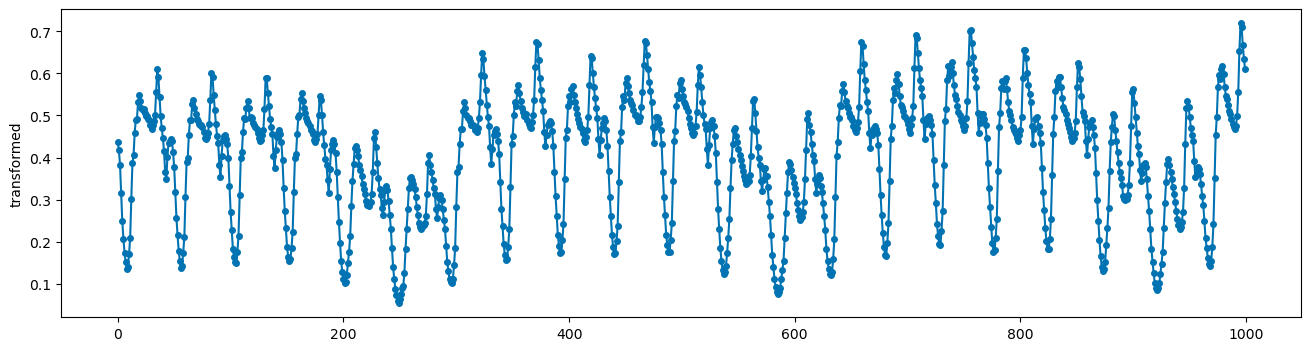

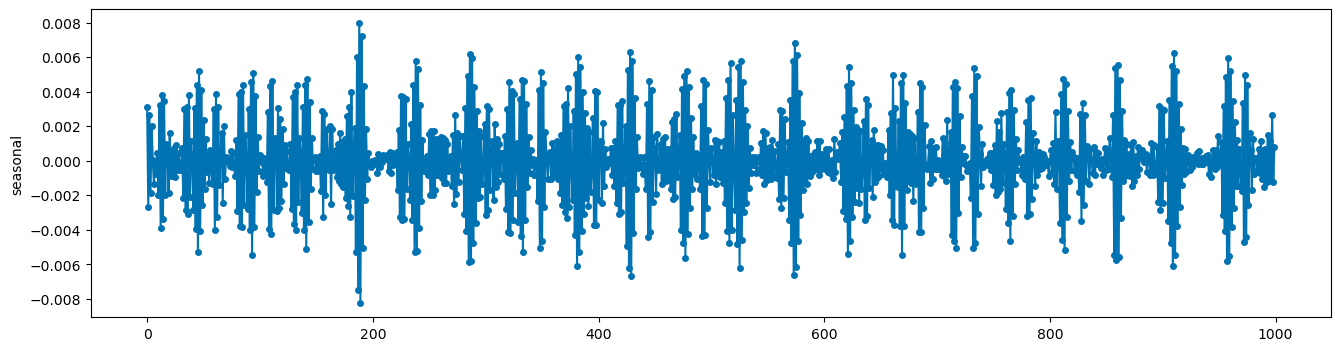

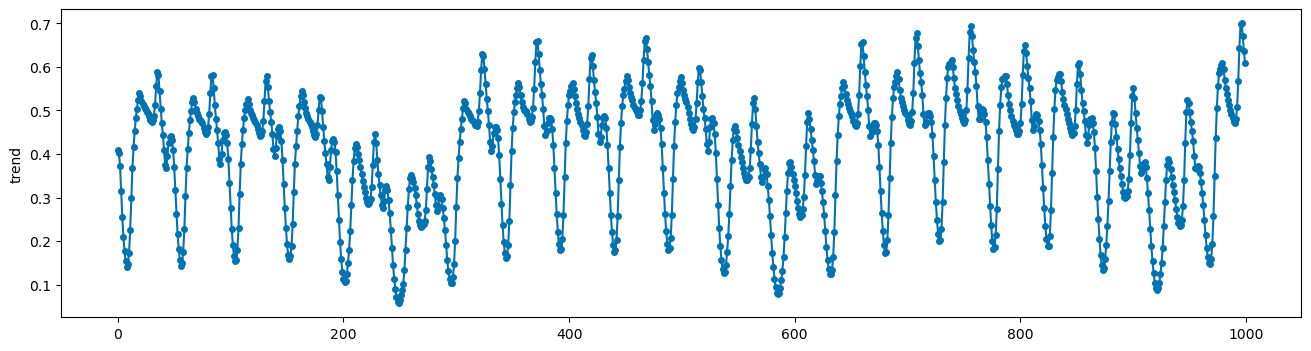

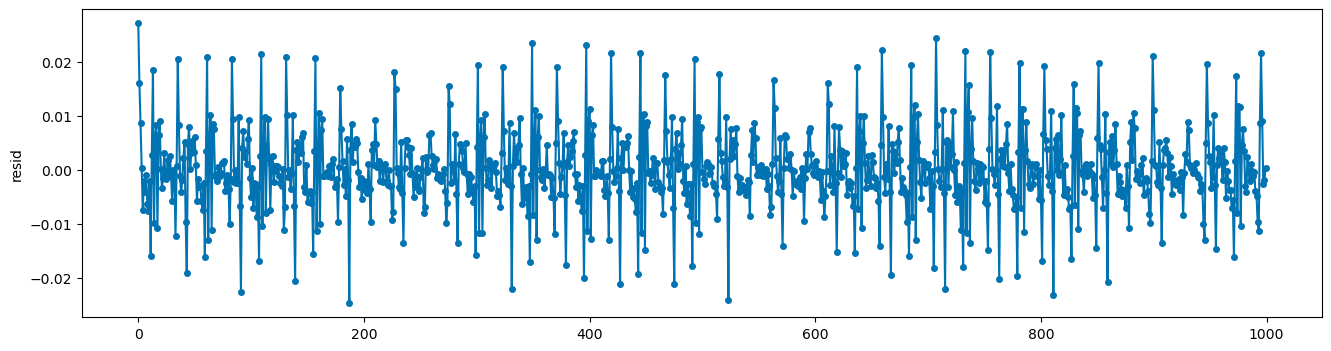

In [58]:
stl = STLTransformer(return_components=True)
y_stl = stl.fit_transform(electricity['nswdemand'])
plot_series(y_stl['transformed'][0:1000])
plot_series(y_stl['seasonal'][0:1000])
plot_series(y_stl['trend'][0:1000])
plot_series(y_stl['resid'][0:1000])

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='nswdemand'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

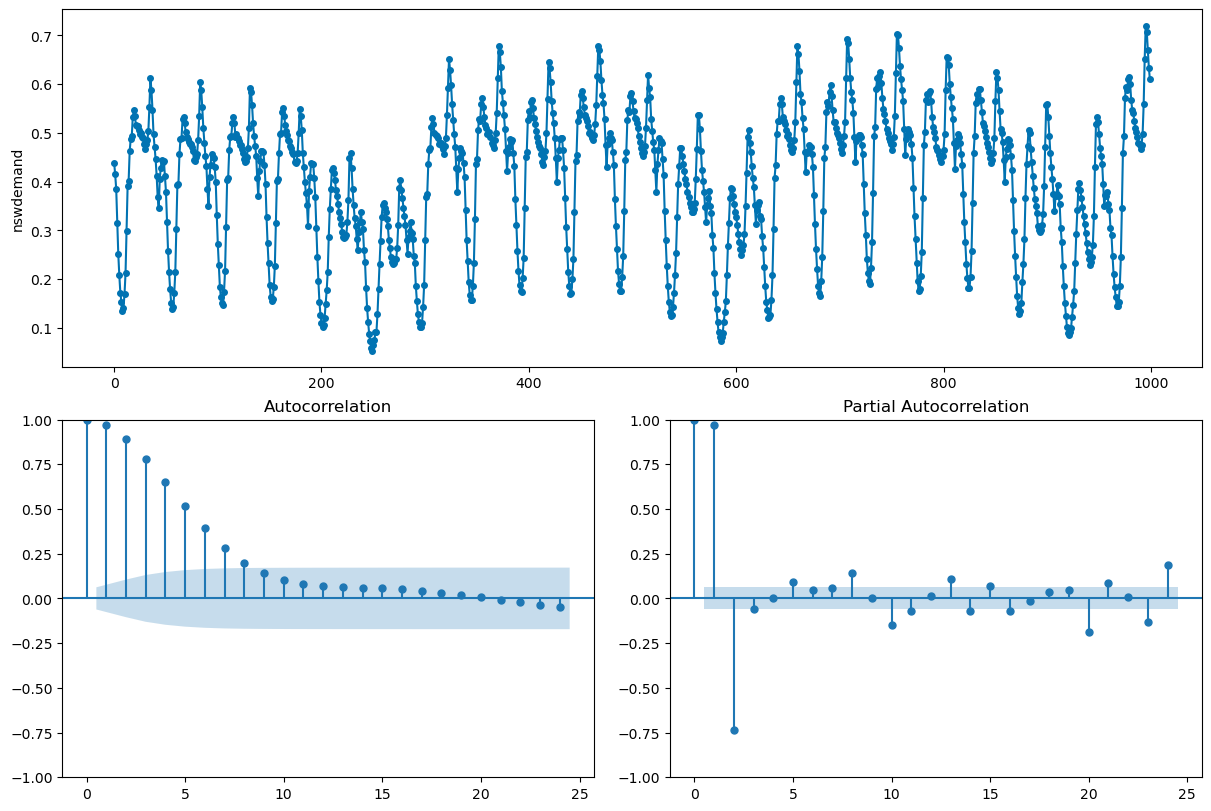

In [65]:
plot_correlations(electricity['nswdemand'][0:1000])

A closer look at the daily seasonality present in the data:

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='nswdemand'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

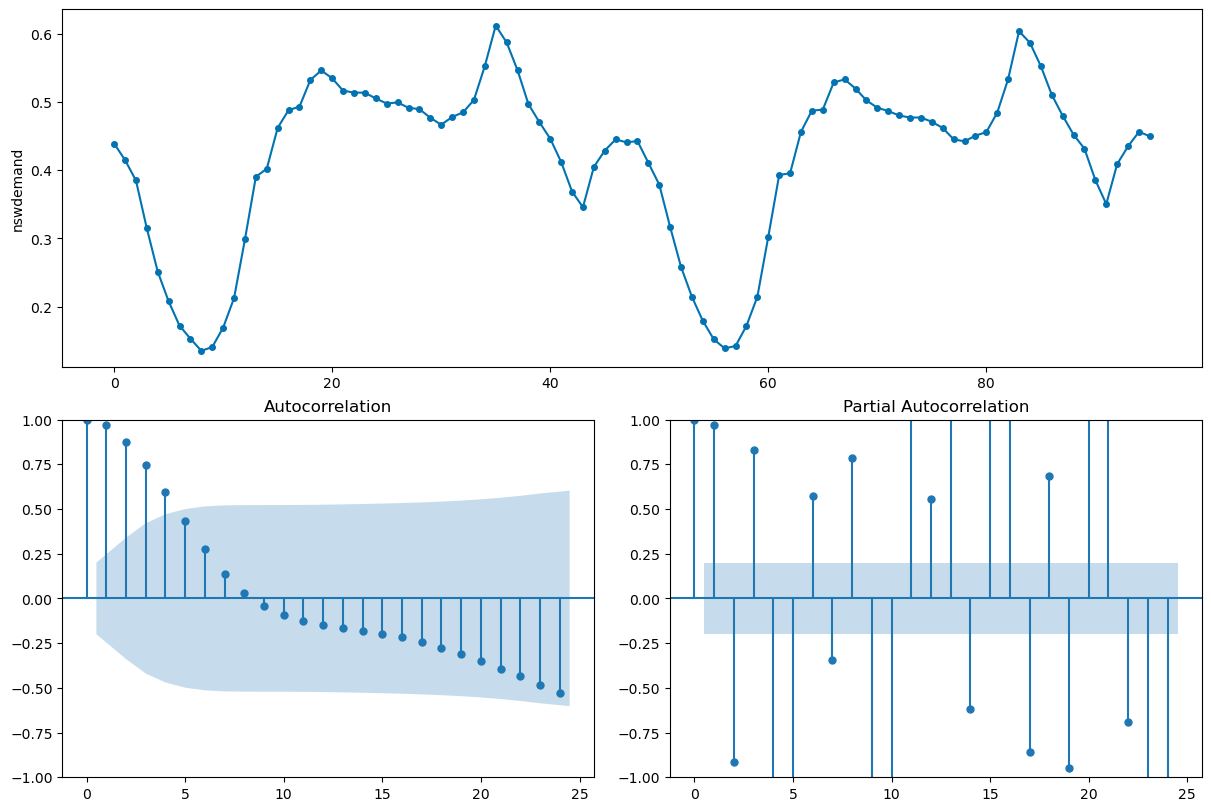

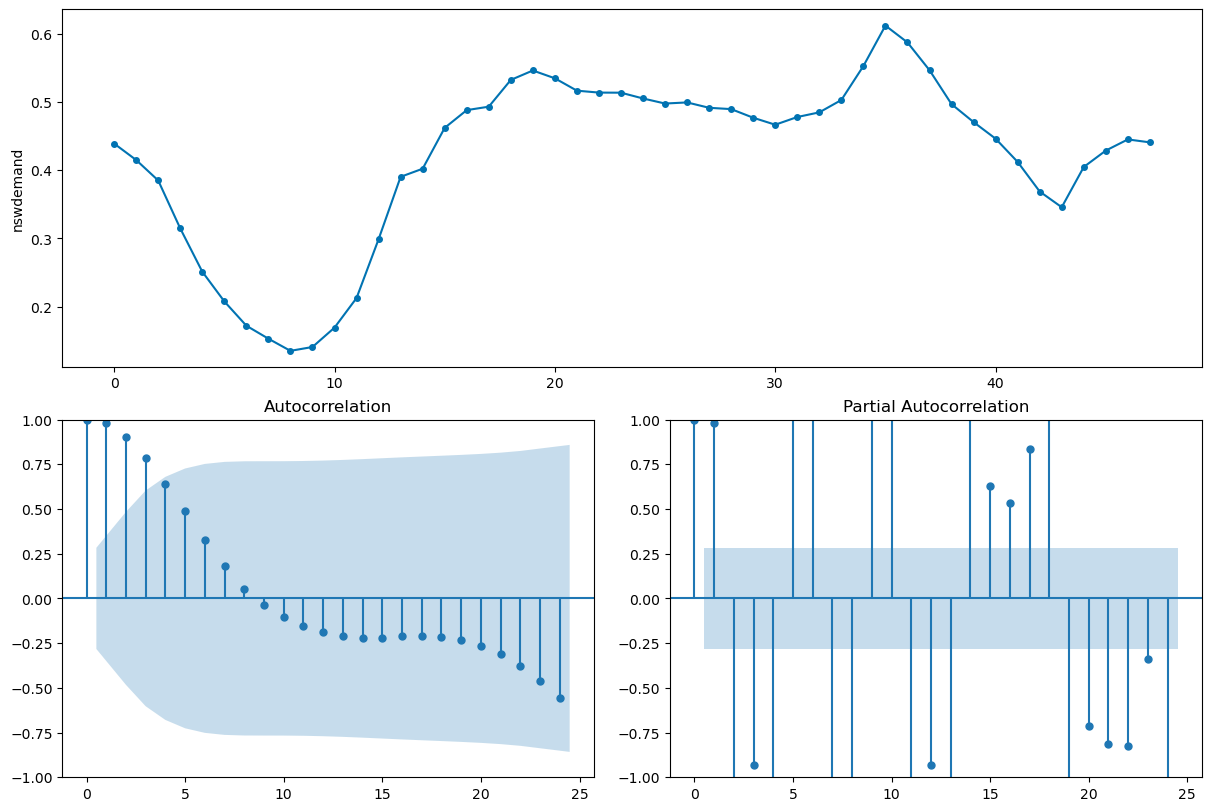

In [66]:
plot_correlations(electricity['nswdemand'][0:96])
plot_correlations(electricity['nswdemand'][0:48])

Prophet is a model developed by Facebook for use in commercial forecasting applications; it has strong out of the box performance in data containing multiple seasonalities and holiday effects. I use a downgraded 1.1.5 version of Prophet due to optimization errors that arise with the 1.1.6 version. 

While the smallest level of granularity in some time series occurs through daily instances, this dataset has observations ever half-hour, meaning the period should be 48 for daily seasonality, 336 for weekly, and so on. We'll have to add these as custom seasonalities to our Prophet model; this is accomplished by adding new custom seasonalities using the add_seasonality argument provided by the sktime wrapper.

Since we're using sktime, it has a slightly different way of handling add_seasonality() than in fbprophet; we have to add multiple custom seasonalities as a list of dictionaries to the constructor.

In [157]:
y = electricity['nswdemand']
y_train, y_test = temporal_train_test_split(y, test_size=0.2)
forecaster = Prophet(
    seasonality_mode='additive',
    add_country_holidays={'country_name': 'Australia'},
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    add_seasonality=[{
        'name': 'daily-cycle',
        'period': 48, # period of 48 representing observations per day
        'fourier_order': 12
    },
    {
        'name': 'weekly-cycle',
        'period': 336, # period of 336 representing 7 day (weekly) cycle
        'fourier_order': 3
    },
    {
        'name': 'yearly-cycle',
        'period': 17520,
        'fourier_order': 10
    }]
)
forecaster.fit(y_train)

19:06:49 - cmdstanpy - INFO - Chain [1] start processing
19:07:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet(add_country_holidays={'country_name': 'Australia'},
        add_seasonality=[{'fourier_order': 12, 'name': 'daily-cycle',
                          'period': 48},
                         {'fourier_order': 3, 'name': 'weekly-cycle',
                          'period': 336},
                         {'fourier_order': 10, 'name': 'yearly-cycle',
                          'period': 17520}],
        daily_seasonality=True, weekly_seasonality=True,
        yearly_seasonality=True)

We then evaluate model performance with mean average percentage error, mean absolute error, and mean squared error.

In [158]:
# Specify forecasting horizon and pass on to forecasting algorithm
y_pred = forecaster.predict(np.arange(len(y_test)))
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"MAPE: {mape} \nMAE: {mae} \nMSE: {mse}")


MAPE: 0.15347452360520786 
MAE: 0.060155303375532855 
MSE: 0.006071706056646205


Let's visually see how our forecasts measure up to the actual values.

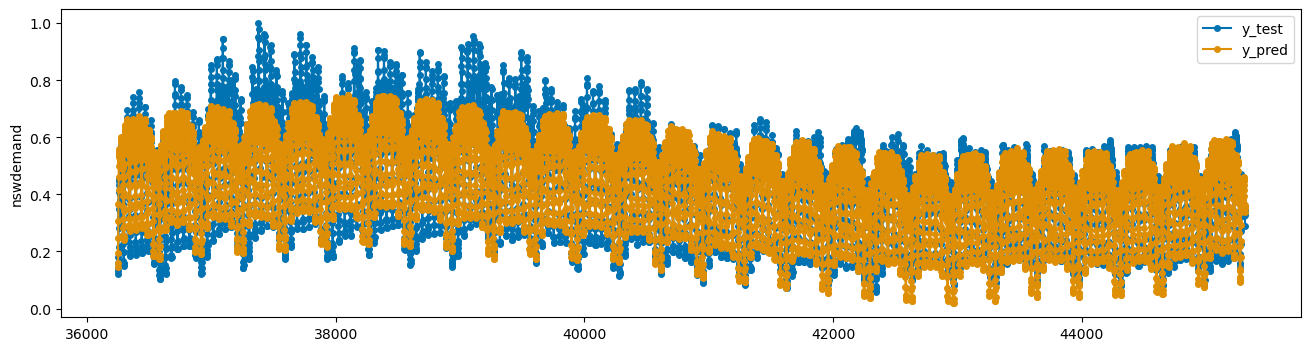

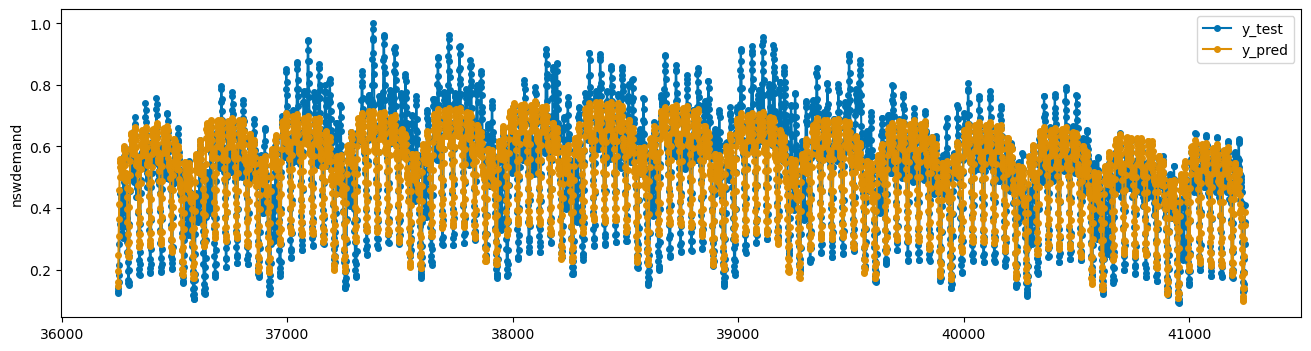

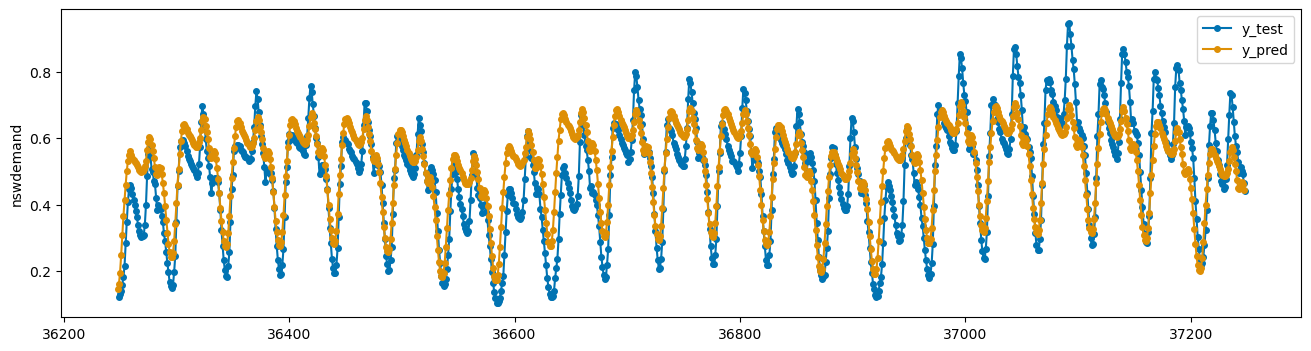

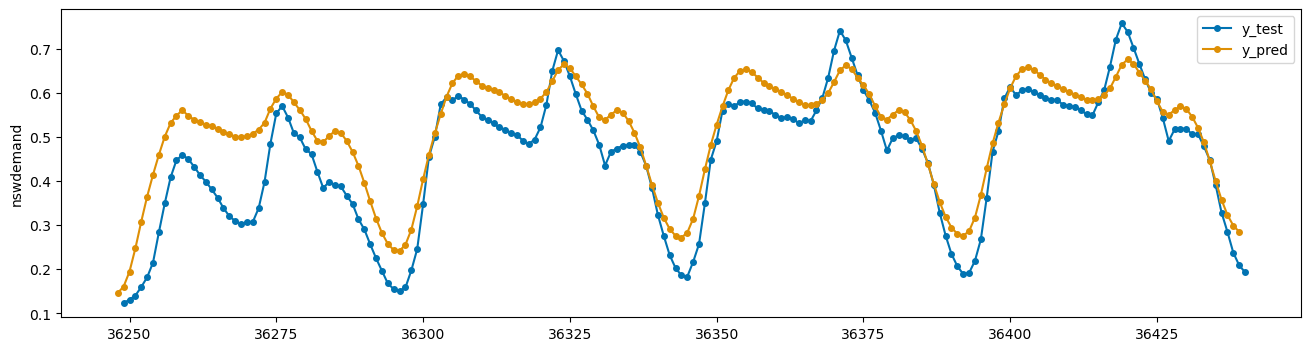

In [159]:
fig, ax = plot_series(y_test, y_pred, labels=["y_test", "y_pred"])
fig, ax = plot_series(y_test[0:5000], y_pred[0:5000], labels=["y_test", "y_pred"])
fig, ax = plot_series(y_test[0:1000], y_pred[0:1000], labels=["y_test", "y_pred"])
fig, ax = plot_series(y_test[0:192], y_pred[0:192], labels=["y_test", "y_pred"])

We can plot the residuals to observe for any remaining seasonal patterns that weren't captured by our model.

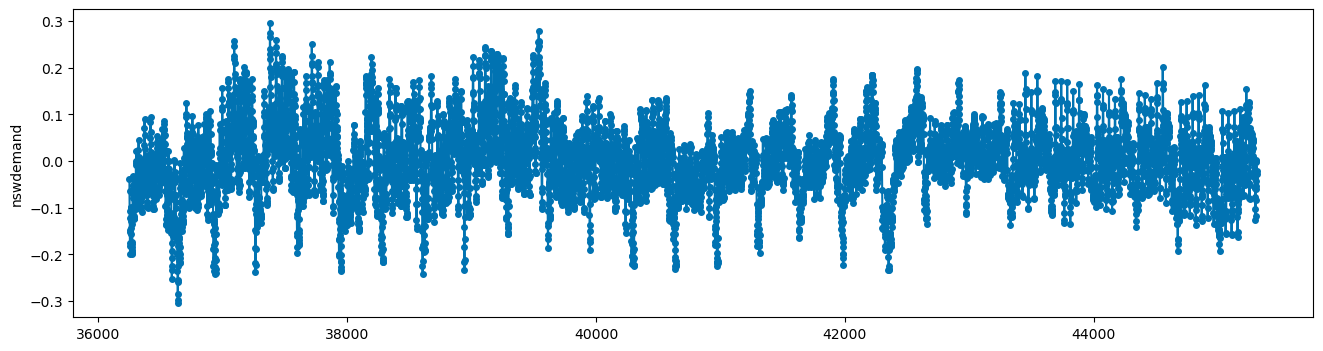

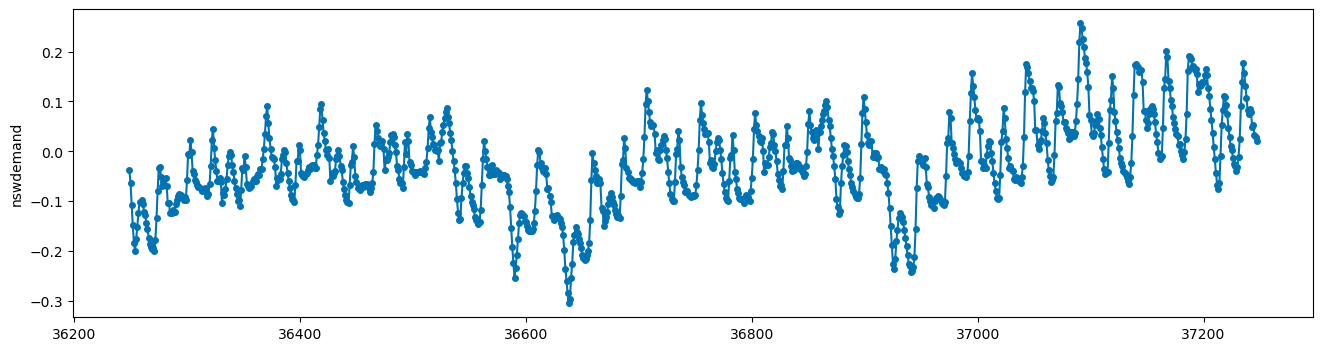

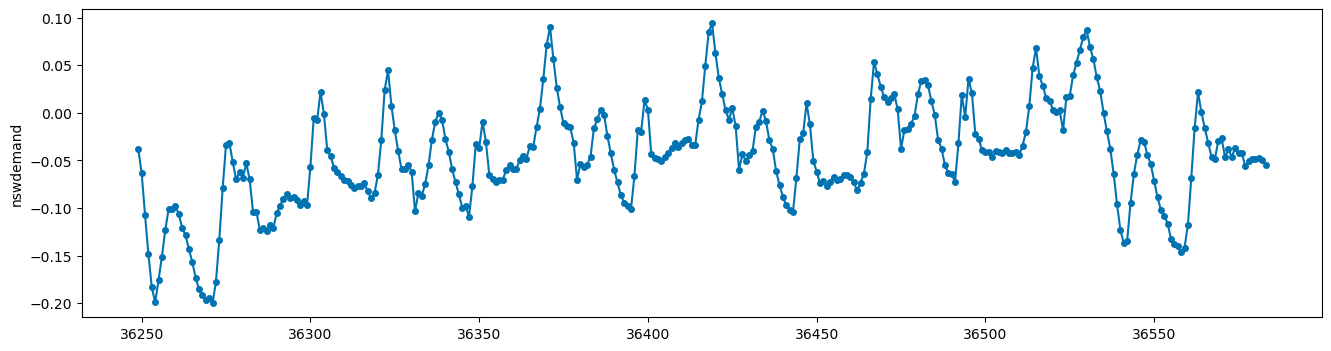

In [160]:
fig, ax = plot_series(y_test[0:17520]-y_pred[0:17520])
fig, ax = plot_series(y_test[0:1000]-y_pred[0:1000])
fig, ax = plot_series(y_test[0:336]-y_pred[0:336])

As can be seen, we've captured a good deal of the daily, weekly, and yearly seasonalities from the original data from our forecast. However, there remains additional patterns in the data that we haven't accounted for. Specifically, it appears that during the first half of the year -in the summer months- the energy demand spikes much more frequently than in the latter half.